In [112]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mne
from mne.stats import spatio_temporal_cluster_test
from mne.datasets import sample
from mne.channels import find_ch_adjacency
from mne.viz import plot_compare_evokeds
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
import file_service as fs
import convert_to_mat
import os
import io_functions as io
import pandas as pd
import mne
import matplotlib.pyplot as plt
from mne.stats import bonferroni_correction, fdr_correction
from scipy import stats
from functools import partial
from mne.stats import (ttest_1samp_no_p, bonferroni_correction, fdr_correction,
                       permutation_t_test, permutation_cluster_1samp_test)

In [2]:
channel_folder_fig_id = "/pl/meg/data/meg_ms/MRN/results/summary/figures/channel"

In [3]:
def scale(data):
    scaler = Scaler(data.info, with_mean=True, with_std=True)
    

In [4]:
def get_meg_data(data_path):
    col_names = ['subject_name', 'subject_path', 'fsiq', 'cognition_composite_score']
    session = pd.read_csv(data_path, sep=',', usecols=col_names)
       
    subject_list = session.values.tolist()
    
    return subject_list

In [5]:
def get_condition_path(condition):
    cond_dict_path_all = {'6':'/pl/meg/analysis/ica_output/data/session1/aud/all',
                  '4':'/pl/meg/analysis/ica_output/data/session1/vis/all',
                  '2':'/pl/meg/analysis/ica_output/data/session1/aud_vis/all'
                  }
    return cond_dict_path_all[condition]

In [6]:
def get_condition_name(condition):
    cond_name = {'6':'aud',
                  '4':'vis',
                  '2':'aud_vis'
                  }
    
    return cond_name[condition]
    

In [7]:
def find_significant_sensors_by_subject(condition, data):
    pass

In [8]:
def find_significant_sensors(condition, data):
    pass
    

In [9]:
def process_subject(subject, condition):
    print("Processing Subject: " + str(subject))
    row  = {}
    row['subject_name'] = subject[0]
    row['subject_path'] = subject[1]
    row['fsiq'] = subject[2]
    row['cognition_composite_score'] = subject[3]   
    
    subject_name = row['subject_name']
    file_name = os.path.basename(subject[1])
    index_of_dot = file_name.index('.')
    file_name_without_extension = file_name[:index_of_dot]
    
    print("Subject " + subject_name + "; Subject Path: " + str(subject[1]))
    
    if os.path.isfile(subject[1]):
        subject_evoked_data = io.read_evokeds_by_path_and_channel_type(subject[1], type='mag',baseline = (-100, 0), condition=condition, verbose=True)
        channels_idx = mne.pick_channels(subject_evoked_data.info['ch_names'], include=[], exclude=[])
    
    return subject_evoked_data

In [10]:
def get_channel_name(channel_id, ch_names):
    return ch_names[channel_id]

In [11]:
def get_channel_adjacency(info, ch_type='mag'):
    adjacency, ch_names = find_ch_adjacency(info, ch_type=ch_type)
    adjacency_fig_id = "magnetometer_channel_adjacency.pdf"
    adjacency_path_fig_id = os.path.join(channel_folder_fig_id, adjacency_fig_id) 
    plt.imshow(adjacency.toarray(), cmap='gray', origin='lower',
           interpolation='nearest')
    plt.xlabel('{} Magnetometers'.format(len(ch_names)))
    plt.ylabel('{} Magnetometers'.format(len(ch_names)))
    plt.title('Between-sensor adjacency')
    fig = plt.gcf()
    fig.set_size_inches(3.9, 3.5)
    plt.savefig(adjacency_path_fig_id, dpi=300)
    plt.close()
    return adjacency, ch_names

In [186]:
def process(condition, data_path):
    cond_folder_path = get_condition_path(condition)
    condition_name = get_condition_name(condition)
    fs.ensure_dir(cond_folder_path)
    subject_list = get_meg_data(data_path)
    
    adjacency_matrix = None
    ch_names = None
    times = None
    info = None
    
    cnt = 0
    subject_evoked_list = []
    subject_array = []
    for s in subject_list: 
        subject_data = process_subject(s,condition)
        if cnt == 0:
            adjacency_matrix, ch_names = get_channel_adjacency(subject_data.info)
            times = subject_data.times
            info = subject_data.info
        
        subject_evoked_list.append(subject_data)
        data = subject_data.data
        subject_array.append(data)
        
        cnt = cnt + 1
        print("Subject Count: " + str(cnt))
        
    all_subjects = np.dstack(subject_array)
    print("All Subjects: " + str(all_subjects.shape))
    all_subjects_clust = np.transpose(all_subjects, (2, 1, 0))
    print("All Subjects Clust : " + str(all_subjects_clust.shape))
    evoked_grand_average = mne.combine_evoked(subject_evoked_list, weights= 'nave')
    return all_subjects, all_subjects_clust, adjacency_matrix, ch_names, times, info, evoked_grand_average

In [142]:
def cluster(X,adjacency, p_val=0.05, threshold = 50.0, n_permutations=100, alpha=0.05):
    
    sigma = 1e-3 
    cluster_stats = spatio_temporal_cluster_test(X, n_permutations=n_permutations,
                                             threshold=threshold, tail=0,
                                             n_jobs=8, 
                                             buffer_size=None,adjacency=adjacency, verbose=True)
    
    t_stat, clusters, p_values, H0 = cluster_stats
    
    #reject_fdr, pval_fdr = fdr_correction(p_val, alpha=alpha, method='indep')
    #threshold_fdr = np.min(np.abs(t_stat)[reject_fdr])
    
    cluster_inds = np.where(p_values < p_val)[0]
    
    print("Significant Clusters Count: " + str(len(cluster_inds)))
    return cluster_inds, t_stat, clusters, p_values, H0
    

In [190]:
def run():
    session1_meta_82path = "/pl/meg/data/meg_ms/MRN/results/summary/subjects_82.csv"
    aud_subjects, aud_subjects_clust, adjacency_matrix_aud, ch_names,  times, info, aud_grand_avg = process('6', session1_meta_82path)
    vis_subjects, vis_subjects_clust, adjacency_matrix, ch_names,  times, info, vis_grand_avg = process('4', session1_meta_82path)
    
    X = [aud_subjects_clust, vis_subjects_clust]   
    threshold_tfce = dict(start=0, step=0.2)
    threshold = 40
    cluster_indexes, T, clusters, p_val, H0 = cluster(X,adjacency_matrix_aud, p_val=0.05, 
                                                      threshold = threshold, n_permutations=100)
    print("p_val: " + str(p_val))
    print("cluster_indexes: " + str(len(cluster_indexes)))
    
    evoked = {'AUD':aud_grand_avg, 'VIS':vis_grand_avg}
    
    return cluster_indexes, T, clusters, p_val, H0, ch_names,  times, info, evoked
    

In [191]:
cluster_indexes, t_stat, clusters, p_val, H0, channel_names, times, info, evoked = run()

Processing Subject: ['M87100788', '/pl/meg/data/meg_ms/MRN/session1/M87100788_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 101, nan]
Subject M87100788; Subject Path: /pl/meg/data/meg_ms/MRN/session1/M87100788_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session1/M87100788_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices av

        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 90 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999-

    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 99 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 11
Processing Subject: ['M87120532', '/pl/meg/data/meg_ms/MRN/session1/M87120532_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 103, 64.0]
Subject M87120532; Subject Path: /pl/meg/data/meg_ms/MRN/session1/M87120532_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/M

Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 16
Processing Subject: ['M87135262', '/pl/meg/data/meg_ms/MRN/session1/M87135262_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 122, 97.0]
Subject M87135262; Subject Path: /pl/meg/data/meg_ms/MRN/session1/M87135262_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session1/M87135262_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.10

    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 91 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0

        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 95 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 27
Processing Subject: ['M87173380', '/pl/meg/data/meg_ms/MRN/session1/M87173380_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 85, 42.0]
Subject M87173380; Subject Path: /pl/meg/data/meg_ms/MRN

Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 32
Processing Subject: ['M87186783', '/pl/meg/data/meg_ms/MRN/session1/M87186783_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 106, 74.0]
Subject M87186783; Subject Path: /pl/meg/data/meg_ms/MRN/session1/M87186783_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session1/M87186783_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-0

Subject Count: 37
Processing Subject: ['M87196579', '/pl/meg/data/meg_ms/MRN/session1/M87196579_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 111, 77.0]
Subject M87196579; Subject Path: /pl/meg/data/meg_ms/MRN/session1/M87196579_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session1/M87196579_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compe

    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 46 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0

        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 98 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 48
Processing Subject: ['M87146442', '/pl/meg/data/meg_ms/MRN/session2/M87146442_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 76, 59.0]
Subject M87146442; Subject Path: /pl/meg/data/meg_ms/MRN

Subject Count: 53
Processing Subject: ['M87155634', '/pl/meg/data/meg_ms/MRN/session2/M87155634_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 103, 53.0]
Subject M87155634; Subject Path: /pl/meg/data/meg_ms/MRN/session2/M87155634_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session2/M87155634_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compe

    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 100 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--

        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 82 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 64
Processing Subject: ['M87191024', '/pl/meg/data/meg_ms/MRN/session2/M87191024_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 119, 53.0]
Subject M87191024; Subject Path: /pl/meg/data/meg_ms/MR

Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 69
Processing Subject: ['M87123871', '/pl/meg/data/meg_ms/MRN/session3/M87123871_multisensory_session3_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 112, 57.0]
Subject M87123871; Subject Path: /pl/meg/data/meg_ms/MRN/session3/M87123871_multisensory_session3_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session3/M87123871_multisensory_session3_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-0

    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 96 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0

        t =    -100.00 ...    1000.00 ms (6)
        0 CTF compensation matrices available
        nave = 84 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 80
Processing Subject: ['M87120532', '/pl/meg/data/meg_ms/MRN/session2/M87120532_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 103, 64.0]
Subject M87120532; Subject Path: /pl/meg/data/meg_ms/MRN/session2/M87120532_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session2/M87120532_multisenso

    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 99 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0

        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 85 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 9
Processing Subject: ['M87117365', '/pl/meg/data/meg_ms/MRN/session1/M87117365_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 135, 69.0]
Subject M87117365; Subject Path: /pl/meg/data/meg_ms/MRN

Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 14
Processing Subject: ['M87132364', '/pl/meg/data/meg_ms/MRN/session1/M87132364_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 110, 60.0]
Subject M87132364; Subject Path: /pl/meg/data/meg_ms/MRN/session1/M87132364_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session1/M87132364_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-0

Subject Count: 19
Processing Subject: ['M87149105', '/pl/meg/data/meg_ms/MRN/session1/M87149105_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 118, 60.0]
Subject M87149105; Subject Path: /pl/meg/data/meg_ms/MRN/session1/M87149105_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session1/M87149105_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 6 projection items:
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 100 - aspect type = 100
Projections have already been applied. Settin

        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 67 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Su

        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 92 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 30
Processing Subject: ['M87184856', '/pl/meg/data/meg_ms/MRN/session1/M87184856_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 136, 49.0]
Subject M87184856; Subject Path: /pl/meg/data/meg_ms/MRN/session1/M87184856_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session1/M87184856_multisenso

Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 35
Processing Subject: ['M87195745', '/pl/meg/data/meg_ms/MRN/session1/M87195745_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 116, 51.7]
Subject M87195745; Subject Path: /pl/meg/data/meg_ms/MRN/session1/M87195745_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session1/M87195745_multisensory_session1_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        ax

    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 93 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0

        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 100 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 46
Processing Subject: ['M87126689', '/pl/meg/data/meg_ms/MRN/session2/M87126689_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 111, 47.0]
Subject M87126689; Subject Path: /pl/meg/data/meg_ms/M

Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 51
Processing Subject: ['M87152059', '/pl/meg/data/meg_ms/MRN/session2/M87152059_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 126, 45.5]
Subject M87152059; Subject Path: /pl/meg/data/meg_ms/MRN/session2/M87152059_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session2/M87152059_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) activ

    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 3 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.

        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 97 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 62
Processing Subject: ['M87183741', '/pl/meg/data/meg_ms/MRN/session2/M87183741_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 104, 51.5]
Subject M87183741; Subject Path: /pl/meg/data/meg_ms/MR

Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 67
Processing Subject: ['M87116480', '/pl/meg/data/meg_ms/MRN/session3/M87116480_multisensory_session3_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 108, 55.0]
Subject M87116480; Subject Path: /pl/meg/data/meg_ms/MRN/session3/M87116480_multisensory_session3_all_tsss_mc_defhead_-hp1-lp50-ave.fif
Reading /pl/meg/data/meg_ms/MRN/session3/M87116480_multisensory_session3_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-0

Reading /pl/meg/data/meg_ms/MRN/session3/M87169425_multisensory_session3_all_tsss_mc_defhead_-hp1-lp50-ave.fif ...
    Read a total of 8 projection items:
        planar-998--0.500-0.500-PCA-01 (1 x 204) active
        planar-998--0.500-0.500-PCA-02 (1 x 204) active
        axial-998--0.500-0.500-PCA-01 (1 x 102) active
        axial-998--0.500-0.500-PCA-02 (1 x 102) active
        planar-999--0.100-0.550-PCA-01 (1 x 204) active
        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 77 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-01, active : True, n_channels : 204>
Removing projector <Projectio

        planar-999--0.100-0.550-PCA-02 (1 x 204) active
        axial-999--0.100-0.550-PCA-01 (1 x 102) active
        axial-999--0.100-0.550-PCA-02 (1 x 102) active
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms (4)
        0 CTF compensation matrices available
        nave = 89 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | planar-998--0.500-0.500-PCA-02, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-01, active : True, n_channels : 204>
Removing projector <Projection | planar-999--0.100-0.550-PCA-02, active : True, n_channels : 204>
Subject Count: 78
Processing Subject: ['M87112743', '/pl/meg/data/meg_ms/MRN/session2/M87112743_multisensory_session2_all_tsss_mc_defhead_-hp1-lp50-ave.fif', 104, 56.0]
Subject M87112743; Subject Path: /pl/meg/data/meg_ms/MRN/session2/M87112743_multisensory_session2


Computing cluster p-values
Done.
Significant Clusters Count: 34
p_val: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01]
cluster_indexes: 34


In [203]:
def get_significant_channels(indexes, t_stat, clusters, p_values, channel_names, times, info, evoked):
    channel_map = {}
    
    colors = {"AUD": "crimson", "VIS": 'steelblue'}
    linestyles = {"AUD": '-', "VIS": '--'}
    for i_clu, clu_idx in enumerate(indexes):
       time_inds, space_inds = np.squeeze(clusters[clu_idx])
       ch_inds = np.unique(space_inds)
       time_inds = np.unique(time_inds)
       
       cnt = 0
       for c_id in ch_inds:
           channel_name = get_channel_name(c_id, channel_names)
           print("Channel Name: " + channel_name)
           channel_map[c_id] = channel_name
           cnt = cnt + 1
        
       f_map = t_stat[time_inds, ...].mean(axis=0)
       print("Channel Count = " + str(cnt))
       print("ch_inds" + str(ch_inds))
       print("time_inds" + str(time_inds))
        
       sig_times =  times[time_inds]
       mask = np.zeros((f_map.shape[0], 1), dtype=bool)
       mask[ch_inds, :] = True

        # initialize figure
       fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))
       f_evoked = mne.EvokedArray(f_map[:, np.newaxis], info, tmin=0)
       f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo,
                          vmin=np.min, vmax=np.max, show=False,
                          colorbar=False, mask_params=dict(markersize=10))
       image = ax_topo.images[0]

       # create additional axes (for ERF and colorbar)
       divider = make_axes_locatable(ax_topo)

       # add axes for colorbar
       ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
       plt.colorbar(image, cax=ax_colorbar)
       ax_topo.set_xlabel(
        'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

       # add new axis for time courses and plot time courses
       ax_signals = divider.append_axes('right', size='300%', pad=1.2)
       title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
       if len(ch_inds) > 1:
          title += "s (mean)"
        
       plot_compare_evokeds(evoked, title=title, picks=ch_inds, axes=ax_signals,
                         colors=colors, show=False,
                         split_legend=True, truncate_yaxis='auto')

       # plot temporal cluster extent
       ymin, ymax = ax_signals.get_ylim()
       ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)

      # clean up viz
       mne.viz.tight_layout(fig=fig)
       fig.subplots_adjust(bottom=.05)
       plt.show()
        
    return channel_map

Channel Name: MEG1521
Channel Name: MEG1531
Channel Name: MEG1641
Channel Name: MEG1711
Channel Name: MEG1721
Channel Name: MEG1731
Channel Name: MEG1741
Channel Name: MEG1931
Channel Name: MEG2131
Channel Name: MEG2331
Channel Name: MEG2511
Channel Name: MEG2521
Channel Name: MEG2531
Channel Name: MEG2541
Channel Count = 14
ch_inds[55 56 61 62 63 64 65 72 80 88 94 95 96 97]
time_inds[204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278]
combining channels using "gfp"
combining channels using "gfp"


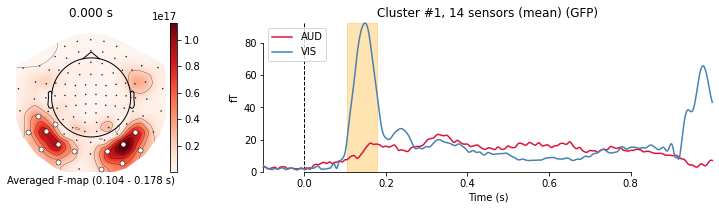

Channel Name: MEG1911
Channel Name: MEG1921
Channel Count = 2
ch_inds[70 71]
time_inds[205 206 207 208 209 210 211 212 213]
combining channels using "gfp"
combining channels using "gfp"


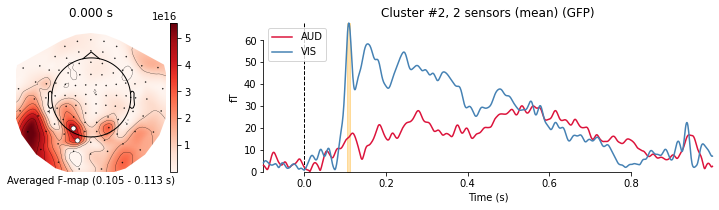

Channel Name: MEG1321
Channel Name: MEG1441
Channel Count = 2
ch_inds[47 53]
time_inds[237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275]
combining channels using "gfp"
combining channels using "gfp"


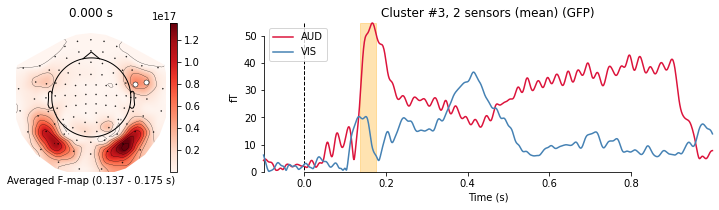

Channel Name: MEG2311
Channel Count = 1
ch_inds[86]
time_inds[242 243 244 245 246 247 248 249 250 251 252 253 254 255]


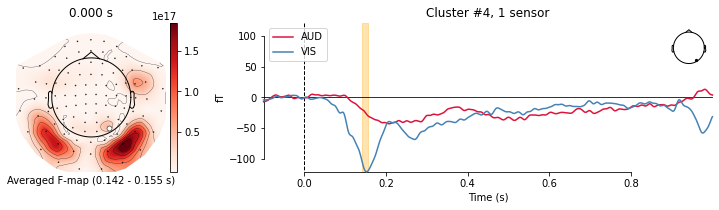

Channel Name: MEG0131
Channel Name: MEG0211
Channel Name: MEG1511
Channel Count = 3
ch_inds[ 2  4 54]
time_inds[264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290]
combining channels using "gfp"
combining channels using "gfp"


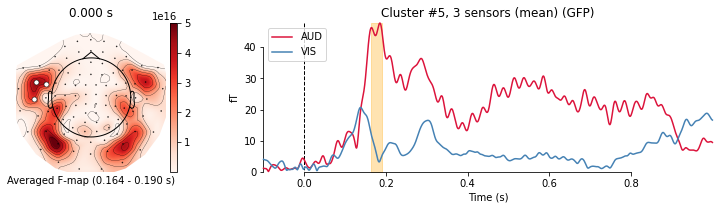

Channel Name: MEG1621
Channel Count = 1
ch_inds[59]
time_inds[279 280 281 282 283]


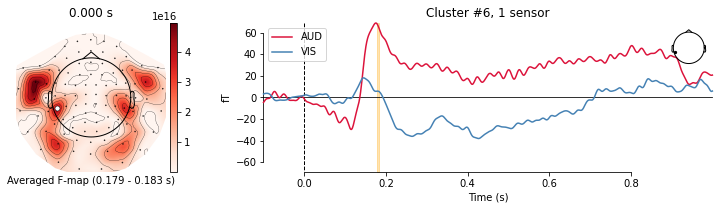

Channel Name: MEG1131
Channel Name: MEG1141
Channel Name: MEG1341
Channel Name: MEG2211
Channel Name: MEG2221
Channel Name: MEG2411
Channel Name: MEG2421
Channel Count = 7
ch_inds[40 41 49 82 83 90 91]
time_inds[283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300
 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318
 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336
 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354
 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372
 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476 47

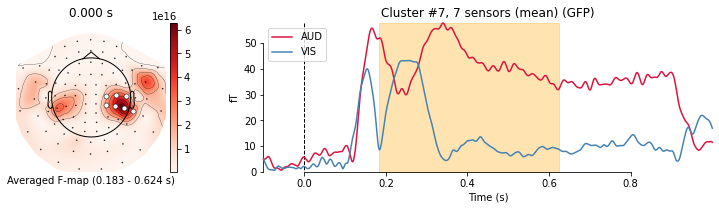

Channel Name: MEG0431
Channel Name: MEG0441
Channel Name: MEG1621
Channel Name: MEG1811
Channel Name: MEG1821
Channel Count = 5
ch_inds[14 15 59 66 67]
time_inds[294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 385 386]
combining channels using "gfp"
combining channels using "gfp"


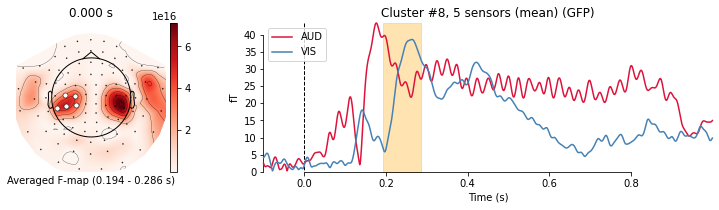

Channel Name: MEG1511
Channel Count = 1
ch_inds[54]
time_inds[304 305]


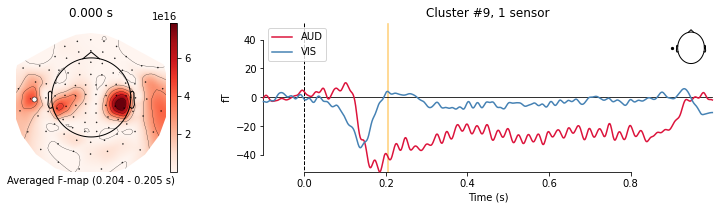

Channel Name: MEG2621
Channel Count = 1
ch_inds[99]
time_inds[305]


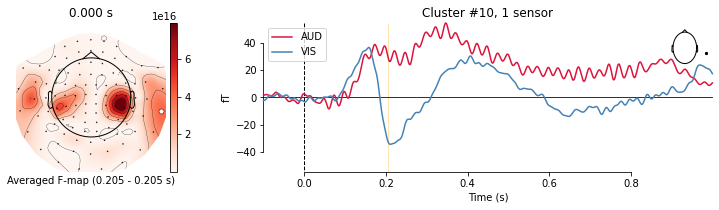

Channel Name: MEG2621
Channel Count = 1
ch_inds[99]
time_inds[311 312 313 314 315 316 317 318 319 320 321 322 323 324 325]


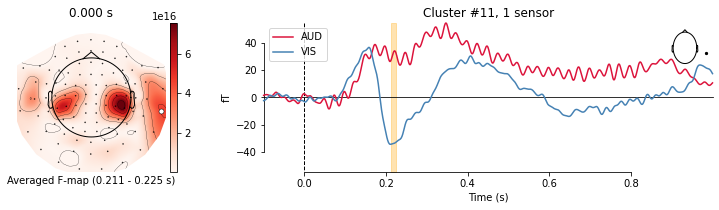

Channel Name: MEG1441
Channel Name: MEG2611
Channel Count = 2
ch_inds[53 98]
time_inds[334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351
 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369
 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387
 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404]
combining channels using "gfp"
combining channels using "gfp"


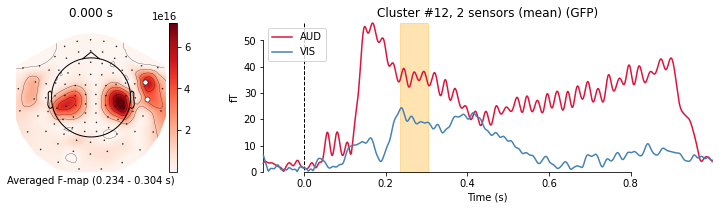

Channel Name: MEG1621
Channel Name: MEG1811
Channel Count = 2
ch_inds[59 66]
time_inds[388 389 390 391 392 393 394 395 396 397 398 399]
combining channels using "gfp"
combining channels using "gfp"


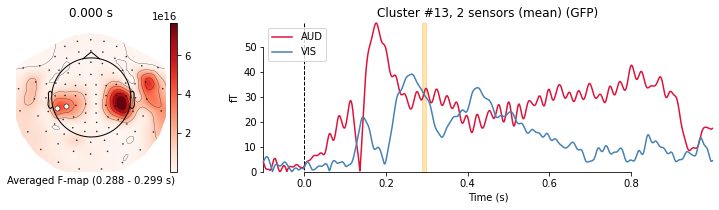

Channel Name: MEG1441
Channel Count = 1
ch_inds[53]
time_inds[417 418 419 420 421 422 423 424 425]


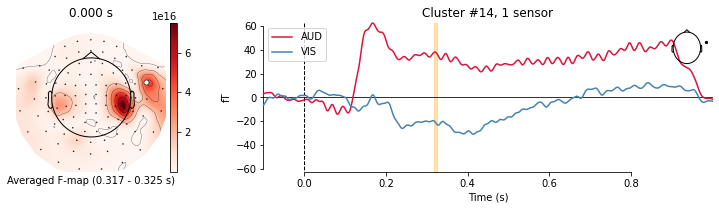

Channel Name: MEG1441
Channel Count = 1
ch_inds[53]
time_inds[443 444 445 446 447 448 449 450 451 452]


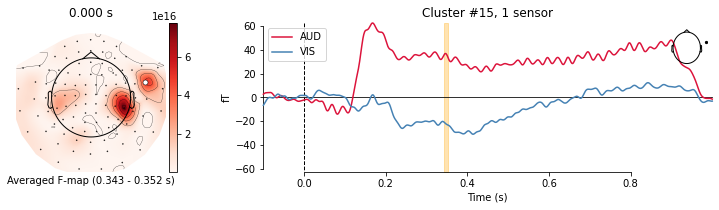

Channel Name: MEG1441
Channel Count = 1
ch_inds[53]
time_inds[463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529]


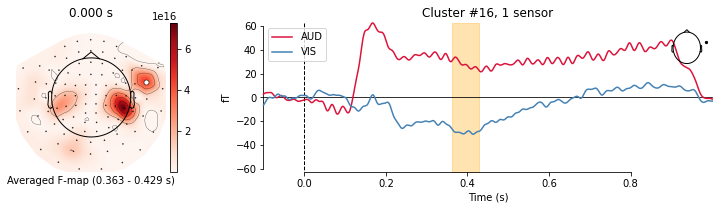

Channel Name: MEG1441
Channel Count = 1
ch_inds[53]
time_inds[546 547 548 549 550]


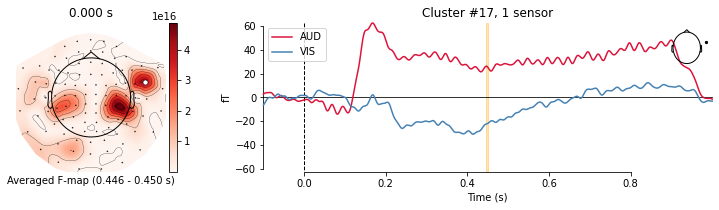

Channel Name: MEG1441
Channel Count = 1
ch_inds[53]
time_inds[575 576 577 578 579 580 581]


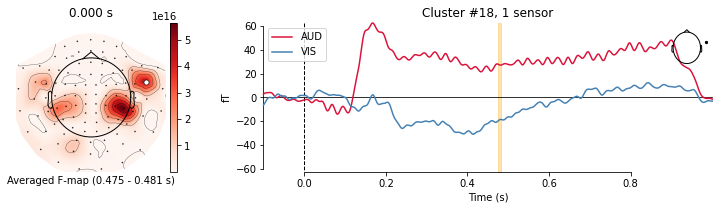

Channel Name: MEG1621
Channel Count = 1
ch_inds[59]
time_inds[697 698 699 700 701 702 703 704]


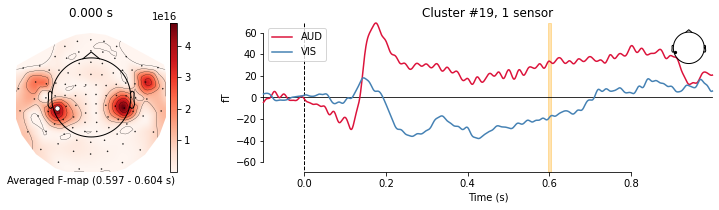

Channel Name: MEG1621
Channel Count = 1
ch_inds[59]
time_inds[716 717 718 719 720 721 722 723]


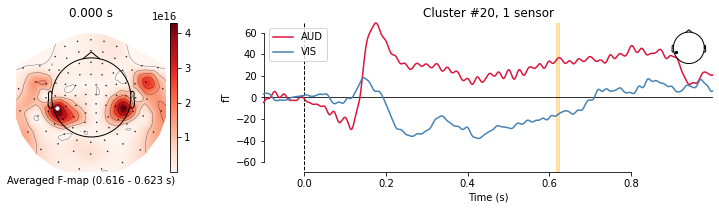

Channel Name: MEG2411
Channel Count = 1
ch_inds[90]
time_inds[730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747
 748 749 750 751 752 753 754 755 756 757 758 759 760 761]


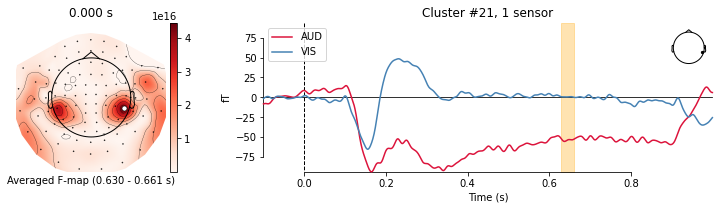

Channel Name: MEG1621
Channel Count = 1
ch_inds[59]
time_inds[768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783]


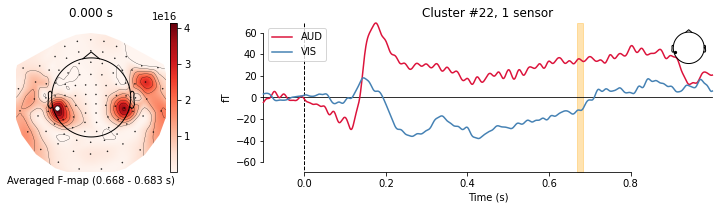

Channel Name: MEG2411
Channel Count = 1
ch_inds[90]
time_inds[788 789 790 791 792 793 794 795]


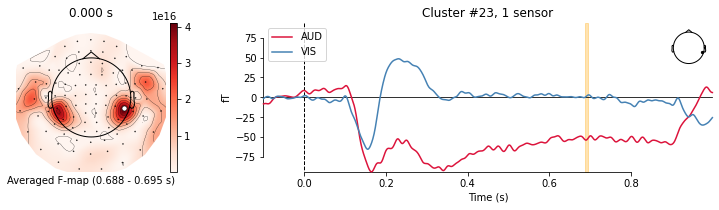

Channel Name: MEG2411
Channel Count = 1
ch_inds[90]
time_inds[836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853
 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871
 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889
 890 891]


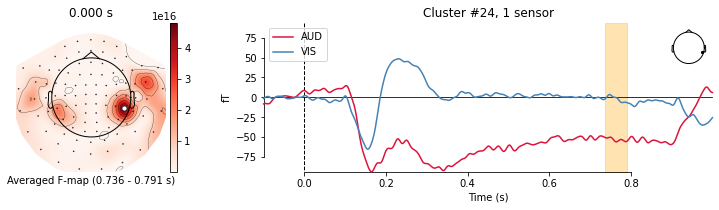

Channel Name: MEG1621
Channel Count = 1
ch_inds[59]
time_inds[900 901 902 903 904 905 906 907]


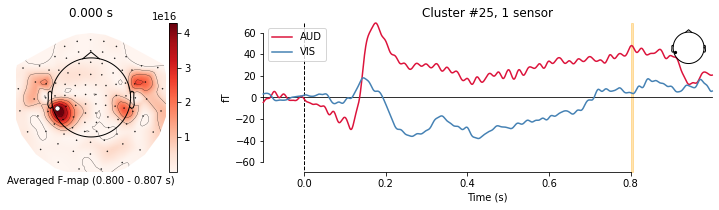

Channel Name: MEG1441
Channel Count = 1
ch_inds[53]
time_inds[917 918 919 920 921 922 923 924 925]


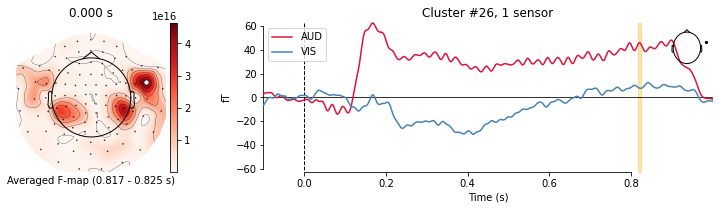

Channel Name: MEG2411
Channel Count = 1
ch_inds[90]
time_inds[920 921 922]


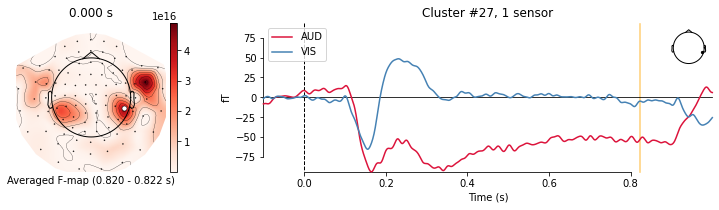

Channel Name: MEG2411
Channel Count = 1
ch_inds[90]
time_inds[935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952
 953]


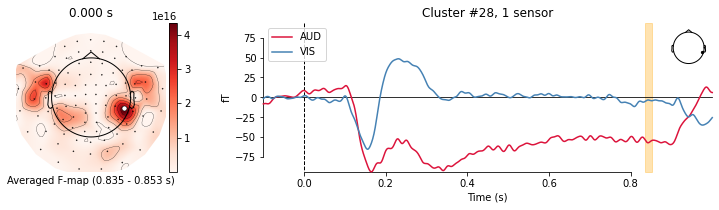

Channel Name: MEG2411
Channel Count = 1
ch_inds[90]
time_inds[961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978
 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996]


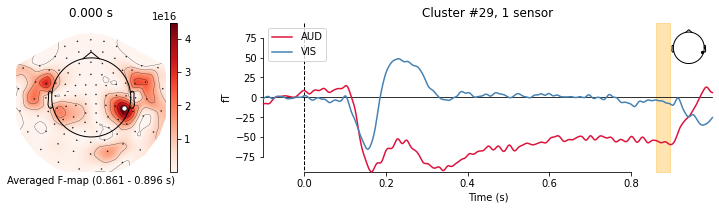

Channel Name: MEG0211
Channel Count = 1
ch_inds[4]
time_inds[976 977 978 979 980]


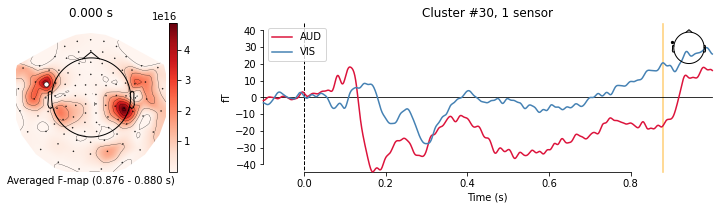

Channel Name: MEG2411
Channel Count = 1
ch_inds[90]
time_inds[1009 1010 1011 1012 1013 1014]


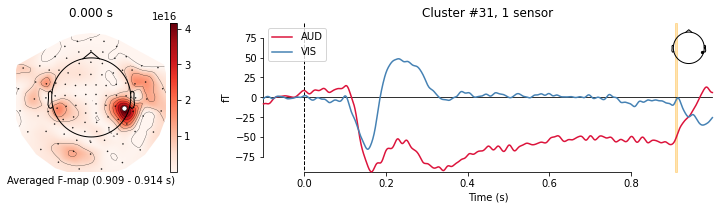

Channel Name: MEG2331
Channel Name: MEG2511
Channel Name: MEG2521
Channel Name: MEG2531
Channel Name: MEG2541
Channel Count = 5
ch_inds[88 94 95 96 97]
time_inds[1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044
 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058
 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072
 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086
 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097 1098 1099 1100]
combining channels using "gfp"
combining channels using "gfp"


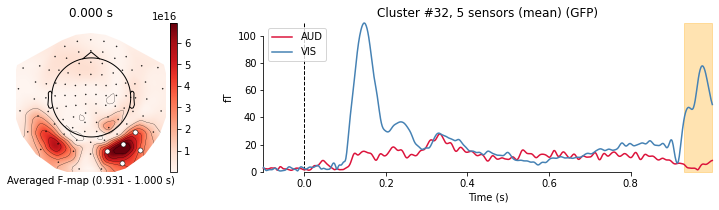

Channel Name: MEG1521
Channel Name: MEG1711
Channel Name: MEG1721
Channel Name: MEG1731
Channel Name: MEG1931
Channel Count = 5
ch_inds[55 62 63 64 72]
time_inds[1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100]
combining channels using "gfp"
combining channels using "gfp"


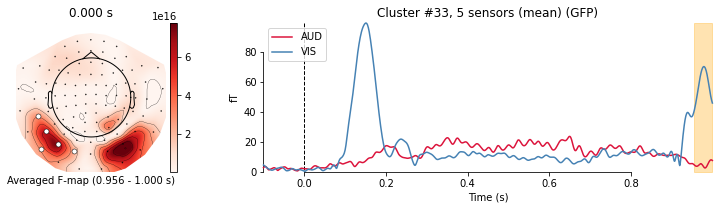

Channel Name: MEG2311
Channel Count = 1
ch_inds[86]
time_inds[1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078
 1079 1080 1081 1082 1083 1084 1085 1086]


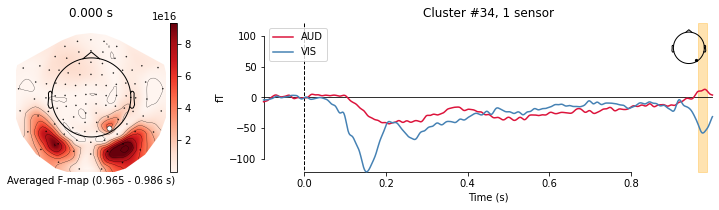

In [204]:
channels = get_significant_channels(cluster_indexes, t_stat, clusters, p_val, channel_names, times, info, evoked)

In [205]:
len(channels)

36

In [206]:
channels

{55: 'MEG1521',
 56: 'MEG1531',
 61: 'MEG1641',
 62: 'MEG1711',
 63: 'MEG1721',
 64: 'MEG1731',
 65: 'MEG1741',
 72: 'MEG1931',
 80: 'MEG2131',
 88: 'MEG2331',
 94: 'MEG2511',
 95: 'MEG2521',
 96: 'MEG2531',
 97: 'MEG2541',
 70: 'MEG1911',
 71: 'MEG1921',
 47: 'MEG1321',
 53: 'MEG1441',
 86: 'MEG2311',
 2: 'MEG0131',
 4: 'MEG0211',
 54: 'MEG1511',
 59: 'MEG1621',
 40: 'MEG1131',
 41: 'MEG1141',
 49: 'MEG1341',
 82: 'MEG2211',
 83: 'MEG2221',
 90: 'MEG2411',
 91: 'MEG2421',
 14: 'MEG0431',
 15: 'MEG0441',
 66: 'MEG1811',
 67: 'MEG1821',
 99: 'MEG2621',
 98: 'MEG2611'}

In [34]:
len(good_cluster_inds)

41903

In [91]:
good_cluster_inds = np.where(p_val < 0.05)[0]

In [102]:
good_cluster_inds

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [90]:
p_val

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [198]:
p_val

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [76]:
len(good_cluster_inds)

38315

In [131]:
p_val

array(0.01)

In [101]:
threshold_bonferroni = stats.t.ppf(1.0 - 0.05 / 1000, 82 - 1)

In [100]:
threshold_bonferroni

3.193921809831454

In [121]:
p_val

array(0.01)